
<h1 align="center">Capstone Project I</h1>

# Introduction #
**Problem Statement**: Classifying Amazon reviews based on customer ratings using NLP

<h4 align="center">Impact</h4>

Reviews provide objective feedback to a product and are therefore inherently useful for consumers. These ratings are often summarized by a numerical rating, or the number of stars. Of course there is more value in the actual text itself than the quantified stars. And at times, the given rating does not truly convey the experience of the product – the heart of the feedback is actually in the text itself. The goal therefore is to build a classifier that would understand the essence of a piece of review and assign it the most appropriate rating based on the meaning of the text.

<h4 align="center">Background</h4>

Though product ratings on Amazon are aggregated from all the reviews by every customer, each individual rating is actually only an integer that ranges from one star to five stars. This reduces our predictions to discrete classes totaling five possibilities. Therefore what we'll have is a supervised, multi-class classifier with the actual review text as the core predictor.

This study is an exploration of Natural Language Processing (NLP). The goal of predicting the star rating given a piece of text will take on different NLP topics including word embedding, topic modeling, and dimension reduction. From there, we'll arrive at a final dataframe and we'll be employing different machine learning techniques in order to come up with the best approach (i.e. most accurate estimator) for our classifier.

<h4 align="center" id="Datasets">Datasets</h4>

The [Amazon dataset](http://jmcauley.ucsd.edu/data/amazon/index.html) contains the customer reviews for all listed *Electronics* products spanning from May 1996 up to July 2014. There are a total of 1,689,188 reviews by a total of 192,403 customers on 63,001 unique products. The data dictionary is as follows:

*  **asin** - Unique ID of the product being reviewed, *string*
*  **helpful** - A list with two elements: the number of users that voted *helpful*, and the total number of users that voted on the review (including the *not helpful* votes), *list*
*  **overall** - The reviewer's rating of the product, *int64*
*  **reviewText** - The review text itself, *string*
*  **reviewerID** - Unique ID of the reviewer, *string*
*  **reviewerName** - Specified name of the reviewer, *string*
*  **summary** - Headline summary of the review, *string*
*  **unixReviewTime** - Unix Time of when the review was posted, *string*

# Data Wrangling #

In [1]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

The `df` is created from the Amazon dataset. If the file has been downloaded then the dataset is loaded from the local file. Otherwise the file is accessed and extracted directly from the repository.

In [2]:
import os
import pandas as pd

dataset="tarun.csv"

if os.path.isfile(dataset):
    df = pd.read_csv("tarun.csv")
else:
    url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)
display(df.head(10))

,Unnamed: 0,0,1,2
0,2698442,2,An Amalgam,This book is an amalgam of bits and pieces and...
1,2646715,5,Great!!!,"Well, not much to say. If you saw the first se..."
2,2119569,2,Hit&Miss,Babyface in his hey day always had a Cut that ...
3,816322,5,Great Buy,This text is considered The Bible for any poli...
4,1476562,3,What time is it anyway?,I thought the other reviews weren't serious ab...
5,17087,3,PRETTY FUNNY,"GOOD,BUT UNREALISTIC.THE GUY JUST QUIT GOING T..."
6,1838666,5,Lacy J. Dalton,I saw Lacy on Bill Anderson's Country Reunion ...
7,1442704,4,Great,Easy and enjoyable to watch. I would recommend...
8,1114640,3,Be careful!!!!,I am a very advanced exerciser and have used t...
9,1308335,5,the best book in the world!!!,Sahara special is one of the best books I have...


In [3]:
df.head()

,Unnamed: 0,0,1,2
0,2698442,2,An Amalgam,This book is an amalgam of bits and pieces and...
1,2646715,5,Great!!!,"Well, not much to say. If you saw the first se..."
2,2119569,2,Hit&Miss,Babyface in his hey day always had a Cut that ...
3,816322,5,Great Buy,This text is considered The Bible for any poli...
4,1476562,3,What time is it anyway?,I thought the other reviews weren't serious ab...


Only the `overall` and the `unixReviewTime` series are stored as integers. The rest are interpreted as strings (objects).

In [4]:
df = df.drop('Unnamed: 0',axis=1)


In [5]:
df.head()

,0,1,2
0,2,An Amalgam,This book is an amalgam of bits and pieces and...
1,5,Great!!!,"Well, not much to say. If you saw the first se..."
2,2,Hit&Miss,Babyface in his hey day always had a Cut that ...
3,5,Great Buy,This text is considered The Bible for any poli...
4,3,What time is it anyway?,I thought the other reviews weren't serious ab...


In [6]:
df.columns=['overall','title','reviewText']


In [7]:
df = df.sample(frac =.25)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187500 entries, 172280 to 280970
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   overall     187500 non-null  int64 
 1   title       187496 non-null  object
 2   reviewText  187500 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.7+ MB
None


In [8]:
df.head()

,overall,title,reviewText
172280,5,Excellent product,I bought this knee brace for my son who was co...
342053,5,"IF YOU LIKE MAPS AND COLOR PICTURES, THIS IS Y...",This is a great book for people who like lots ...
345256,2,Would be great but BUGGY,"This game has so much potential, but it is fil..."
82597,5,Works as expected.,"It's no frills, which is all I wanted. The cor..."
425572,1,horrible,"horrible, absurd, cartoonish, ridiculous. do n..."


# Word Frequency - Initial

In [9]:
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

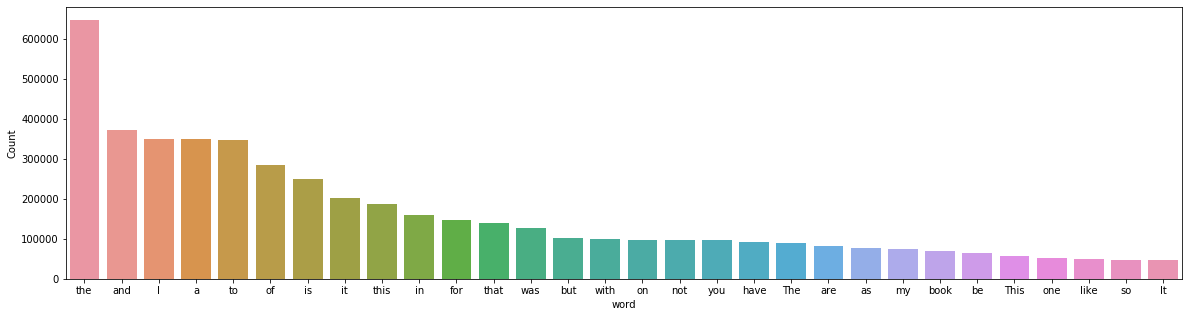

In [10]:
freq_words(df['reviewText'])

The `reviewTime` is dropped since the `unixReviewTime` series more accurately describes the time when each review was posted.

In [11]:
print(df["reviewText"].iloc[0])

I bought this knee brace for my son who was coming off of knee surgery(torn meniscus) He wore these knee pads from November to march, wrestling in 45 matches and daily practices. these pads were excellent in the way they cushioned his knee and protected him from any injury. the only down side was the cloth fabric sleeve's(holder) became worn out late in the season and it was required to be wrapped with tape around the top of the pad so it would stay up. i plan on purchasing another pair before next wrestling season.


Each review is associated with a rating stored under the `overall` field. This serves as the quantified summary of a given review and will thus be used as the ground truth labels for the model.

In [12]:
print(df.overall.unique())

[5 2 1 4 3]


## NLP Pre-Processing ##
We'll work with `reviewText` to prepare our model's final dataframe. The goal is to produce tokens for every document (i.e. every review). These documents will make up our corpora where we'll draw our vocabulary from.

The following is a sample text in its original form.

In [13]:
sample_review = df["reviewText"].iloc[1]
print(sample_review)

This is a great book for people who like lots of pictures and maps. It not only provides you with tips on travel (phonec calls,money ect) but it gives you insight into the different sections of the Loire. Each major attraction has one or more pages dedicated to it. The book really gives you a feel for what you will be seeing. It is one of the best guide books i have ever bought. I liked it so much i bought the one for Paris.


### HTML Entities ###
Some special characters like the apostrophe (’) and the en dash (–) are expressed as a set of numbers prefixed by `&#` and suffixed by `;`. This is because the dataset was scraped from an HTML parser, and the dataset itself includes data that predated the universal UTF-8 standard.

These *HTML Entities* can be decoded by importing the `html` library.

In [14]:
import html

decoded_review = html.unescape(sample_review)
print(decoded_review)

This is a great book for people who like lots of pictures and maps. It not only provides you with tips on travel (phonec calls,money ect) but it gives you insight into the different sections of the Loire. Each major attraction has one or more pages dedicated to it. The book really gives you a feel for what you will be seeing. It is one of the best guide books i have ever bought. I liked it so much i bought the one for Paris.


Since punctuation marks do not add value in the way we'll perform NLP, all the HTML entities in the review texts can be dropped. The output series `preprocessed` is our `reviewText` but without the special characters.

In [15]:
pattern = r"\&\#[0-9]+\;"

df["preprocessed"] = df["reviewText"].str.replace(pat=pattern, repl="", regex=True)

print(df["preprocessed"].iloc[1])

This is a great book for people who like lots of pictures and maps. It not only provides you with tips on travel (phonec calls,money ect) but it gives you insight into the different sections of the Loire. Each major attraction has one or more pages dedicated to it. The book really gives you a feel for what you will be seeing. It is one of the best guide books i have ever bought. I liked it so much i bought the one for Paris.


### Extracting the root word ###
How often a word is used is key information in natural language processing. It is therefore important to reduce words to their root form. An example would be the usage of the word "*learn*". If we differentiate this base form from a modified version like "*learning*" then we might lose relational context between two documents that have used either word.

We'll be using Lemmatization to reduce tokens to their base word. This technique takes into account context similarity according to part-of-speech anatomy. Stemming is another common approach, although stemming only performs truncation and would not be able to reduce "*taught*" to "*teach*".

We will be using the *WordNetLemmatizer* from the Natural Language Toolkit (or *NLTK*). Lemmatization only applies to each word but it is dependent on sentence structure to understand context. We therefore need to have part-of-speech tags associated with each word. Our output is derived from applying the `lemmatize_doc` function to our `preprocessed` column.

The `lemmatize_doc` works as follows:
* Each review is broken down into a list of sentences
* Punctuations that only group words or separate sentences (hyphens therefore are excluded) are removed (replaced by whitespace) using RegEx
* Every sentence is further broken down into words (tokens)

Each of the sentences then becomes an ordered bag of words. Every word is then *tagged* to a part-of-speech. This word-tag tuple pair is then fed one at a time to the `lemmatize_word` function, which works as follows:
* Only modifiable words – nouns, verbs, adjectives, and adverbs – can be reduced to roots
* These words are lemmatized and appended to the `root` list
* Words that are not modifiable are added as they are to the `root` list

The output lists are linked together as a string using whitespace. In the end, each `preprocessed` review will retain its text form but with each word simplified as much as possible.

In [16]:
%%time
import re
import nltk

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet

#import nltk resources
#resources = ["wordnet", "stopwords", "punkt", \
#             "averaged_perceptron_tagger", "maxent_treebank_pos_tagger"]
resources =["wordnet", "stopwords"]

for resource in resources:
    try:
        nltk.data.find("tokenizers/" + resource)
    except LookupError:
        nltk.download(resource)

#create Lemmatizer object
lemma = WordNetLemmatizer()

def lemmatize_word(tagged_token):
    """ Returns lemmatized word given its tag"""
    root = []
    for token in tagged_token:
        tag = token[1][0]
        word = token[0]
        if tag.startswith('J'):
            root.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            root.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            root.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            root.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            root.append(word)
    return root

def lemmatize_doc(document):
    """ Tags words then returns sentence with lemmatized words"""
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", " ", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_word(tagged_token)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)

#apply our functions
df["preprocessed"] = df["preprocessed"].apply(lambda row: lemmatize_doc(row))

print(df["preprocessed"].iloc[1])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This be a great book for people who like lot of picture and map It not only provide you with tip on travel phonec call money ect but it give you insight into the different section of the Loire Each major attraction have one or more page dedicate to it The book really give you a feel for what you will be see It be one of the best guide book i have ever buy I like it so much i buy the one for Paris
Wall time: 19min 47s


### Removing Accents ###
Each review is normalized from longform UTF-8 to ASCII encoding. This will remove accents in characters and ensure that words like "*naïve*" will simply be interpreted as (and therefore not differentiated from) "*naive*".

In [17]:
from unicodedata import normalize

remove_accent = lambda text: normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

df["preprocessed"] = df["preprocessed"].apply(remove_accent)

print(df["preprocessed"].iloc[1])

This be a great book for people who like lot of picture and map It not only provide you with tip on travel phonec call money ect but it give you insight into the different section of the Loire Each major attraction have one or more page dedicate to it The book really give you a feel for what you will be see It be one of the best guide book i have ever buy I like it so much i buy the one for Paris


### Removing Punctuations ###
The `preprocessed` reviews are further cleaned by dropping punctuations. Using regular expressions, only whitespaces and alphanumeric characters are kept.

In [18]:
pattern = r"[^\w\s]"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

This be a great book for people who like lot of picture and map It not only provide you with tip on travel phonec call money ect but it give you insight into the different section of the Loire Each major attraction have one or more page dedicate to it The book really give you a feel for what you will be see It be one of the best guide book i have ever buy I like it so much i buy the one for Paris


### Converting to Lower Case ###
Every letter is also converted to lower case. This makes it so that "*iPhone*" will not be distinguishable from "*iphone*".

In [19]:
df["preprocessed"] = df["preprocessed"].str.lower()

print(df["preprocessed"].iloc[1])

this be a great book for people who like lot of picture and map it not only provide you with tip on travel phonec call money ect but it give you insight into the different section of the loire each major attraction have one or more page dedicate to it the book really give you a feel for what you will be see it be one of the best guide book i have ever buy i like it so much i buy the one for paris


### Removing Stop Words ###
Stop words consist of the most commonly used words that include pronouns (e.g. *us*, *she*, *their*), articles (e.g. *the*), and prepositions (e.g. *under*, *from*, *off*). These words are not helpful in distinguishing a document from another and are therefore dropped.

Note that the `stop_words` were stripped of punctuations just as what we have done to our dataset.

In [20]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

stop_words = [word.replace("\'", "") for word in stop_words]

print(f"sample stop words: {stop_words[:15]} \n")

remove_stop_words = lambda row: " ".join([token for token in row.split(" ") \
                                          if token not in stop_words])
df["preprocessed"] = df["preprocessed"].apply(remove_stop_words)

print(df["preprocessed"].iloc[1])

sample stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'youre', 'youve', 'youll', 'youd', 'your', 'yours'] 

great book people like lot picture map provide tip travel phonec call money ect give insight different section loire major attraction one page dedicate book really give feel see one best guide book ever buy like much buy one paris


### Removing Extra Spaces ###
Again, we make use of regular expressions to ensure we never get more than a single whitespace to separate words in our sentences.

In [21]:
pattern = r"[\s]+"

df["preprocessed"] = df["preprocessed"].str.replace(pat=pattern, repl=" ", regex=True)

print(df["preprocessed"].iloc[1])

great book people like lot picture map provide tip travel phonec call money ect give insight different section loire major attraction one page dedicate book really give feel see one best guide book ever buy like much buy one paris


# Word Frequency

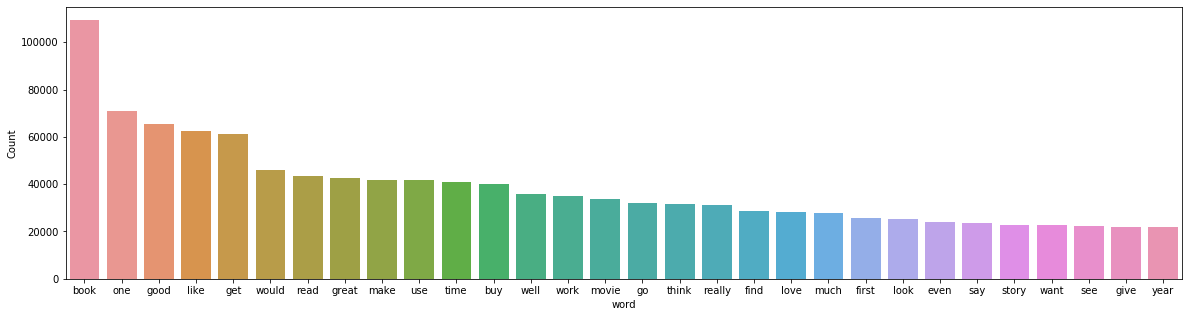

In [22]:
freq_words(df["preprocessed"])

## Tokenization ##
The entries for the `preprocessed` column are extracted to make up our *corpora*, which is simply a collection of all our documents. Each review is then transformed into an ordered list of words. This is the process of *tokenization* – the document is broken down into individual words or tokens.

Our tokenized sample review is below:

In [23]:
corpora = df["preprocessed"].values
tokenized = [corpus.split(" ") for corpus in corpora]

print(tokenized[1])

['great', 'book', 'people', 'like', 'lot', 'picture', 'map', 'provide', 'tip', 'travel', 'phonec', 'call', 'money', 'ect', 'give', 'insight', 'different', 'section', 'loire', 'major', 'attraction', 'one', 'page', 'dedicate', 'book', 'really', 'give', 'feel', 'see', 'one', 'best', 'guide', 'book', 'ever', 'buy', 'like', 'much', 'buy', 'one', 'paris']


## Phrase Modeling ##
Since order of words matter in most NLP models, it is often helpful to group neighboring words that appear to convey one meaning as though they are a single word, like *smart TV*.

To be considered a *phrase*, the number of times that two words should appear next to each other is set to at least `300`. The *threshold* then takes that minimum and compares it to the total number of token instances in the corpora. The higher the threshold, the more often two words must appear adjacent to be grouped into a phrase.

In [24]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bi_gram = Phrases(tokenized, min_count=300, threshold=50)

tri_gram = Phrases(bi_gram[tokenized], min_count=300, threshold=50)

### Unigrams ###
Unigrams are single pieces of tokens. The code below takes all the unique words from the entire corpora and prints a sample:

In [25]:
uni_gram_tokens = set([token for text in tokenized for token in text])
uni_gram_tokens = set(filter(lambda x: x != "", uni_gram_tokens))

print(list(uni_gram_tokens)[:50])

['thisresult', 'afterhe', 'dedicated', 'lawnchair', 'answersand', 'panicked', 'maimi', 'disintegrationcocteau', 'smomething', 'victems', 'beyondhis', 'snacks', 'loosend', 'inteligant', 'blurbings', '6amp', 'propagandai', 'giambi', 'guideline', 'sixshooter', 'woman2', 'oversensitive', 'portrayer', 'obscure', 'classring', 'hhr', 'arnulfo', 'technogly', 'siddeeq', 'drivil', 'badging', 'weaponary', 'muskateer', 'supprise', 'rtf', 'spelt', 'moralistic', 'cassablancas', 'geeeeez', 'austrianor', 'osmand', 'yurt', 'nist', 'another', 'brey', 'jenre', 'borde', 'whincing', 'conquered', 'yossef']


### Bigrams ###
Bigrams are generated from using the *gensim* phraser. Only those that pass the `bi_gram` criteria are considered.

The code below takes all the unique bigram phrases from the entire corpora:

In [26]:
bigram_min = bi_gram.min_count

bi_condition = lambda x: x[1] >= bigram_min

bi_gram_tokens = dict(filter(bi_condition, bi_gram.vocab.items()))
bi_gram_tokens = set([token.decode("utf-8") \
                      for token in bi_gram_tokens])

bi_grams_only = bi_gram_tokens.difference(uni_gram_tokens)
print(list(bi_grams_only)[:50])

['', 'find_good', 'people_say', 'take_long', 'would_want', 'know_would', 'wan_na', 'worth_price', '15_year', 'great_book', 'four_star', 'would_go', 'reason_give', '4_5', 'still_good', '2_day', 'never_see', 'end_book', 'short_story', 'tv_show', 'wish_could', 'well_think', 'give_3', 'find_way', 'many_different', 'blu_ray', 'one_time', 'lot_good', 'r_b', 'book_recommend', 'one_last', 'civil_war', 'make_one', 'many_book', 'product_work', 'anyone_else', 'everything_else', 'time_get', 'would_love', 'couple_year', 'good_read', 'piece_junk', 'enjoy_movie', 'great_cd', 'say_book', 'fit_well', '20_minute', 'best_song', 'least_one', 'like_say']


### Trigrams ###
Trigrams are generated by applying another *gensim* phraser on top of a bigram phraser. Take for example the tokens *sd* and *card*. Because they appear often together enough, they become linked together as *sd_card*. In turn, if *sd_card* appears adjacent to the token *reader* in enough instances, then the `tri_gram` model would link them together as well to tokenize *sd_card_reader*.

The code below takes all the unique trigram phrases from the entire corpora:

In [27]:
trigram_min = tri_gram.min_count

tri_condition = lambda x: x[1] >= trigram_min

tri_gram_tokens = dict(filter(tri_condition, tri_gram.vocab.items()))
tri_gram_tokens = set([token.decode("utf-8") \
                       for token in tri_gram_tokens])

tri_grams_only = tri_gram_tokens.difference(bi_gram_tokens)
print(list(tri_grams_only)[:50])

['would_highly_recommend', 'highly_recommend_book']


The `tri_gram` and `bi_gram` phrasers are applied to our `tokenized` corpora.

In [28]:
#tokenized = [Phraser(tri_gram)[Phraser(bi_gram)[i]] for i in tokenized]

Single-character tokens are removed from every tokenized document. Our tokenized review, in its final form, is below.

In [29]:
tokenized = [list(filter(lambda x: len(x) > 1, document)) \
             for document in tokenized]

print(tokenized[1])

['great', 'book', 'people', 'like', 'lot', 'picture', 'map', 'provide', 'tip', 'travel', 'phonec', 'call', 'money', 'ect', 'give', 'insight', 'different', 'section', 'loire', 'major', 'attraction', 'one', 'page', 'dedicate', 'book', 'really', 'give', 'feel', 'see', 'one', 'best', 'guide', 'book', 'ever', 'buy', 'like', 'much', 'buy', 'one', 'paris']


## Creating the Vocabulary ##
The `vocabulary` is the key-value pairs of all the unique tokens from every product review. Each token is assigned a lookup ID. The first 10 words in our dictionary are as follows:

In [30]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: 45
ID: 1, Token: another
ID: 2, Token: around
ID: 3, Token: become
ID: 4, Token: brace
ID: 5, Token: buy
ID: 6, Token: cloth
ID: 7, Token: come
ID: 8, Token: cushion
ID: 9, Token: daily


## Count-based Feature Engineering ##
In order for a machine learning model to work with text input, the document must first be *vectorized*. This simply means that the input has to be converted into containers of numerical values.

### Bag of Words Model ###
The classical approach in expressing text as a set of features is getting the token frequency. Each entry to the dataframe is a document while each column corresponds to every unique token in the entire corpora. The row will identify how many times a word appears in the document. The `bow` model for the sample review is below:

In [31]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: 45, Frequency: 1
Word: another, Frequency: 1
Word: around, Frequency: 1
Word: become, Frequency: 1
Word: brace, Frequency: 1
Word: buy, Frequency: 1
Word: cloth, Frequency: 1
Word: come, Frequency: 1
Word: cushion, Frequency: 1
Word: daily, Frequency: 1
Word: excellent, Frequency: 1
Word: fabric, Frequency: 1
Word: holder, Frequency: 1
Word: injury, Frequency: 1
Word: knee, Frequency: 4
Word: late, Frequency: 1
Word: march, Frequency: 1
Word: match, Frequency: 1
Word: meniscus, Frequency: 1
Word: next, Frequency: 1
Word: november, Frequency: 1
Word: pad, Frequency: 3
Word: pair, Frequency: 1
Word: plan, Frequency: 1
Word: practice, Frequency: 1
Word: protect, Frequency: 1
Word: purchase, Frequency: 1
Word: require, Frequency: 1
Word: season, Frequency: 2
Word: side, Frequency: 1
Word: sleeve, Frequency: 1
Word: son, Frequency: 1
Word: stay, Frequency: 1
Word: surgery, Frequency: 1
Word: tape, Frequency: 1
Word: top, Frequency: 1
Word: torn, Frequency: 1
Word: way, Frequency: 1
Wo

### TF-IDF Model ###
The Term Frequency-Inverse Document Frequency (*TF-IDF*) approach assigns continuous values instead of simple integers for the token frequency. Words that appear frequently overall tend to not establish saliency in a document, and are thus weighted lower. Words that are unique to some documents tend to help distinguish it from the rest and are thus weighted higher. The `tfidf` weighting is based on our `bow` variable.

In [32]:
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow)

for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: 45, Weight: 0.125
Word: another, Weight: 0.058
Word: around, Weight: 0.065
Word: become, Weight: 0.075
Word: brace, Weight: 0.158
Word: buy, Weight: 0.036
Word: cloth, Weight: 0.133
Word: come, Weight: 0.048
Word: cushion, Weight: 0.137
Word: daily, Weight: 0.108
Word: excellent, Weight: 0.070
Word: fabric, Weight: 0.124
Word: holder, Weight: 0.122
Word: injury, Weight: 0.146
Word: knee, Weight: 0.541
Word: late, Weight: 0.087
Word: march, Weight: 0.133
Word: match, Weight: 0.100
Word: meniscus, Weight: 0.233
Word: next, Weight: 0.072
Word: november, Weight: 0.143
Word: pad, Weight: 0.324
Word: pair, Weight: 0.102
Word: plan, Weight: 0.091
Word: practice, Weight: 0.102
Word: protect, Weight: 0.115
Word: purchase, Weight: 0.056
Word: require, Weight: 0.094
Word: season, Weight: 0.187
Word: side, Weight: 0.076
Word: sleeve, Weight: 0.133
Word: son, Weight: 0.079
Word: stay, Weight: 0.080
Word: surgery, Weight: 0.144
Word: tape, Weight: 0.096
Word: top, Weight: 0.076
Word: torn, Wei

## Word Embedding for Feature Engineering ##
The downside of count-based techniques is that without regard to word sequence and sentence structure, the semantics get lost. The *Word2Vec* technique, on the other hand, actually embeds meaning in vectors by quantifying how often a word appears within the vicinity of a given set of other words.

A context window the span of `context_size` slides across every document one token at a time. In each step, the center word is described by its adjacent words and the probability that the token appears together with the others is expressed in `feature_size` dimensions. Since the minimum word requirement is set to `1`, every token in the corpora is embedded in the *Word2Vec* model.

In [33]:
%%time
import numpy as np

from gensim.models import word2vec

np.set_printoptions(suppress=True)

feature_size = 100
context_size = 20
min_word = 1

word_vec= word2vec.Word2Vec(tokenized, size=feature_size, \
                            window=context_size, min_count=min_word, \
                            iter=50, seed=42)

Wall time: 6min 35s


## Final Dataframe ##
The goal is to have a dataframe with observations corresponding to the product reviews. The `word_vec` model is used to gather all the unique tokens in the corpora. This enables us to generate the `word_vec_df` which makes use of the dimensions as the features of every word.

In [34]:
word_vec_unpack = [(word, idx.index) for word, idx in \
                   word_vec.wv.vocab.items()]

tokens, indexes = zip(*word_vec_unpack)

word_vec_df = pd.DataFrame(word_vec.wv.syn0[indexes, :], index=tokens)

display(word_vec_df.head())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
buy,-0.391614,0.214361,-0.297795,-1.877798,-4.291623,-0.978395,-0.937741,0.463861,-2.089837,-2.478668,...,-2.204032,1.829290,-3.479812,-0.199290,0.338583,-2.067757,4.804310,-2.475281,-0.648905,2.271200
knee,1.481127,-1.978232,-5.700877,1.706983,0.162963,1.898773,-2.902293,0.457745,2.619406,1.072991,...,-2.497428,-1.427017,-2.086283,1.251740,-3.486538,-1.234355,2.849387,1.263205,-2.140125,1.255013
brace,2.338521,-1.144466,-4.394060,-1.000188,-0.073849,0.861388,-4.325711,-1.433344,3.800290,-1.003659,...,-1.449026,-0.469251,-3.572661,0.682496,-5.588127,1.907107,2.072536,-1.930896,0.755664,-1.787867
son,-0.784669,-4.240441,-0.102267,2.689479,-0.944507,1.638644,-0.295057,-1.015112,-6.617234,0.473892,...,1.646912,-7.015779,-2.300763,2.594702,-2.190922,5.335032,-0.068625,1.043740,2.853506,-0.789644
come,-0.860967,-2.615756,2.044501,0.057479,-1.821402,-0.822883,-2.908396,1.012116,-2.599405,-1.368737,...,-0.183804,-0.565112,-0.204980,-5.581378,3.131901,-1.471195,1.289782,-2.469403,-0.555767,-1.916383


The `word_vec_df` is sliced by the words that appear in a given `tokenized` review and the mean along every dimension is taken. The resulting `model_array` shape is therefore the word count on *axis 0* and the number of dimensions on *axis 1*. This singularizes multiple word embeddings into one observation for each review.

If multiple occurrences of a word occurs in a review, then this only emphasizes the token since the row is pulled towards the values of the vectors of that word.

In [35]:
%%time
tokenized_array = np.array(tokenized)

model_array = np.array([word_vec_df.loc[doc].mean(axis=0) for doc in tokenized_array])

Wall time: 2min 10s


Every document is provided the ground truth label by imposing its `overall` rating. This completes our finalized `model_df` dataframe.

In [36]:
model_df = pd.DataFrame(model_array)
model_df["label"] = df["overall"]

display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,1.060511,-0.188223,-1.115128,0.362478,0.119871,0.998860,-1.463232,-0.143590,-0.202608,0.693012,...,-1.900333,-1.395217,0.004696,-0.846067,0.007666,0.698607,-0.440302,0.402417,0.177233,NaN
1,0.891368,-0.790383,-1.417212,0.748750,-1.663503,-0.814701,-0.004924,0.921140,-0.263571,-1.453477,...,-0.612079,0.629601,0.779798,0.906917,0.025658,0.577646,0.190882,1.190661,0.824445,NaN
2,0.992819,-0.578294,-1.753037,-0.246599,0.621295,0.340919,0.657904,0.068378,-0.548838,-0.889405,...,-0.298908,0.132332,0.660255,-0.103366,-0.825894,0.063889,0.006260,-0.778452,-0.055913,NaN
3,-0.047363,0.841540,-1.503287,0.574135,1.264495,0.401423,-0.114395,-0.111660,0.992983,-1.897826,...,-0.561008,-1.178640,0.296056,1.037051,-1.279606,0.767893,-0.765034,2.213472,1.210326,NaN
4,1.256347,-0.637179,-1.493984,1.059257,-0.970549,-1.404447,-0.472565,1.561990,-2.069466,0.201867,...,-1.325816,0.038941,-0.327367,1.010343,-0.590240,0.791885,1.099817,-0.458528,0.494933,NaN


## Principal Component Analysis ##
Principal Component Analysis (*PCA*) is a dimensionality reduction technique that we can use on our `model_df` to reduce its 100 dimensions to just two dimensions. This will help visualize if there is a clear decision boundary along the five `overall` rating classifications. The more datapoints belonging to the same class are clustered together, the higher the likelihood that our machine learning model is simpler and more effective.

# TD-IDF

In [37]:
df.dropna(inplace=True)
df = df[df['overall']!= 3]
df['Positively_Rated'] = np.where(df['overall']>3, 1, 0)
df.head(100)

,overall,title,reviewText,preprocessed,Positively_Rated
172280,5,Excellent product,I bought this knee brace for my son who was co...,buy knee brace son come knee surgery torn meni...,1
342053,5,"IF YOU LIKE MAPS AND COLOR PICTURES, THIS IS Y...",This is a great book for people who like lots ...,great book people like lot picture map provide...,1
345256,2,Would be great but BUGGY,"This game has so much potential, but it is fil...",game much potential fill fatal bug patch yet a...,0
82597,5,Works as expected.,"It's no frills, which is all I wanted. The cor...",frill want cord long enough conveniently place...,1
425572,1,horrible,"horrible, absurd, cartoonish, ridiculous. do n...",horrible absurd cartoonish ridiculous waste tw...,0
...,...,...,...,...,...
681236,4,bubble gum music lives!,Hail to bobby sherman! Now HE WAS THE ULTIMATE...,hail bobby sherman ultimate pin poster good lo...,1
473291,4,They're blind and deaf or liars or idiots or a...,THE AUDIO AND VIDEO OF THIS FLICK ARE JUST FIN...,audio video flick fine find tame see ever shoc...,1
546197,5,Best Marley kids' album yet,This cd is great. It is both smoothe and relax...,cd great smoothe relaxing intense sensitive ev...,1
607499,4,Attactor Factor,This Book in incredible for keeping you on tra...,book incredible keep track focus positive thin...,1


In [38]:
pd.crosstab(index = df['Positively_Rated'], columns="Total count")

col_0,Total count
Positively_Rated,
0,75011
1,74854


In [39]:
from sklearn.model_selection import train_test_split
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['reviewText'], df['Positively_Rated'], test_size=0.20, random_state=0)

In [40]:
print('X_train first entry:\n\n', X_train.iloc[2])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry:

 "Swedish Exodus" is an indespensible reference for Swedish researchers. In these pages one can find out why so many Swedes decided to come to America, how they mananged it, where they emigrated to in America, how many came during each year of the mass migration, how many remigrated each year, how many came from each major Swedish district, and how they did in America. It even outlines the consequences of the emigration on Sweden. It is nicely indexed, contains a useful bibliography, and is illustrated with photos and drawings.


X_train shape:  (119892,)


In [41]:
from sklearn.feature_extraction.text import CountVectorizer
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)
# Array mapping from feature integer indices to feature name
vect.get_feature_names()[::200]

['00',
 '0stars',
 '10rock',
 '130mbs',
 '1600g',
 '1860',
 '1997s',
 '20dbgain',
 '2500mah',
 '2inches',
 '32',
 '38oz',
 '4137',
 '4ever',
 '530platinum',
 '5vdc',
 '6980',
 '77121',
 '8830',
 '970hd',
 '_the',
 'abdiel',
 'absalom',
 'accents',
 'accustome',
 'acrobats',
 'adaptable',
 'adjustible',
 'advaita',
 'aewsome',
 'afternoons',
 'agregarlos',
 'airforce',
 'alaska',
 'alford',
 'allister',
 'alround',
 'amang',
 'america',
 'amplio',
 'and2',
 'ane',
 'ankrum',
 'answeres',
 'antrim',
 'apertures',
 'apple15',
 'aprons',
 'architectandsoothing',
 'ariginal',
 'array',
 'asan',
 'aspergers',
 'asterix',
 'athough',
 'attention',
 'auktyon',
 'automoton',
 'avril',
 'azkaban',
 'bachmann',
 'baduk',
 'balked',
 'banished',
 'barkley',
 'basiclly',
 'battlebegin',
 'bealer',
 'becaurfull',
 'beforehand',
 'belgian',
 'beneficiary',
 'berries',
 'beutiful',
 'bifocal',
 'biogeography',
 'biters',
 'bladeplay',
 'blightfully',
 'blowhards',
 'boaz',
 'boll',
 'book3',
 'boots',

Now you have tokenized matrix of text document or reviews, you can use Logistic Regression or any other classifier to classify between the Negative and Positive Reviews for the limitation of this tutorial and just to show the intent of text classification and feature extraction techniques let us use logistic regression. Before you do that just have a look how feature matrix look like, using Vectorizer.transform() to make a document term matrix.

In [42]:
feature_name = vect.get_feature_names()
print("Number of Features: {}".format(len(feature_name)))

Number of Features: 126851


In [43]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
print('Shape of matrix', X_train_vectorized.shape)
print(X_train_vectorized.toarray()[2])

Shape of matrix (119892, 126851)


MemoryError: Unable to allocate 113. GiB for an array with shape (119892, 126851) and data type int64

In [ ]:
X_train_vectorized

# First Classification Model

Now, you are ready to build your first classification model, you are using sklearn.linear_model.LogisticRegression() from scikit learn as our first model.

In [44]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
# Train the model
model = LogisticRegression()

model.fit(vect.transform(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Model Scoring

From the Logistic Regression Output you can use AUC metric to validate or test your model on Test dataset, just to make sure how good a model is performing on new dataset.

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)


AUC:  0.8523519467454541


In [46]:
from sklearn import metrics
def eval_predictions(y_test, y_pred):
    print ('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print ('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print ('recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    print ('F-measure:', metrics.f1_score(y_test, y_pred, average='weighted'))
eval_predictions(y_test, predictions)

accuracy: 0.8523004036966604
precision: 0.8524629062074897
recall: 0.8523004036966604
F-measure: 0.8522933833876125


Text(0.5, 0, 'False Positive Rate')

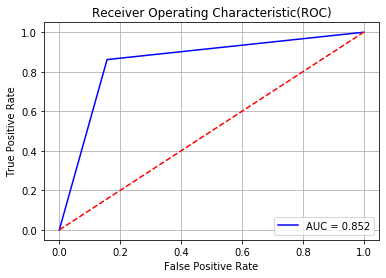

In [47]:
from matplotlib import pyplot as plt
plt.title('Receiver Operating Characteristic(ROC)')
plt.grid()
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [48]:
from sklearn.model_selection import learning_curve
from sklearn import svm
# Create CV training and test scores for various training set sizes

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(),
                                               vect.transform(X_train), y_train, cv=2, scoring='accuracy', n_jobs=-1,
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

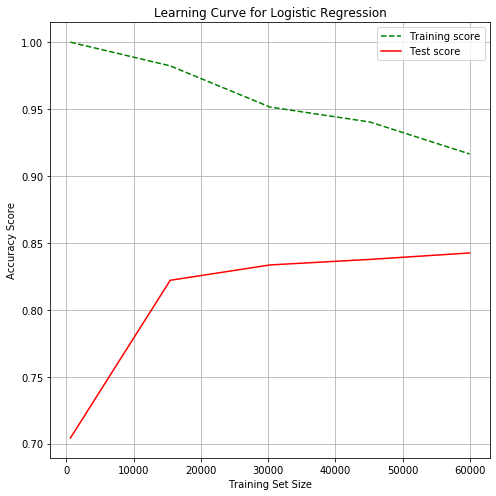

In [55]:
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Draw lines
plt.subplots(1, figsize=(7,7))
plt.grid()
plt.plot(train_sizes, train_mean, '--', color='green',  label="Training score")
plt.plot(train_sizes, test_mean, color='red', label="Test score")

    # Draw bands
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

# 2nd MOdel - Random Forest

In [50]:
#from sklearn.linear_model import RandomForest,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
# Train the model

forest = RandomForestClassifier(n_estimators=2, class_weight={0:10, 1:12}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train_vectorized, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 10, 1: 12}, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=2, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Predict the transformed test documents
predictions = forest.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)


AUC:  0.6275784838481578


In [52]:
eval_predictions(y_test, predictions)

accuracy: 0.6287325259400127
precision: 0.654662315246596
recall: 0.6287325259400127
F-measure: 0.6115282793990658


Text(0.5, 0, 'False Positive Rate')

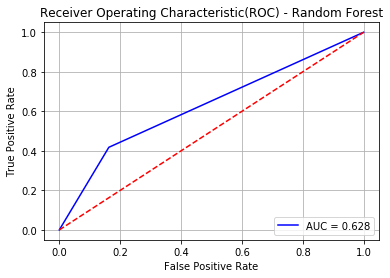

In [53]:
from matplotlib import pyplot as plt
plt.title('Receiver Operating Characteristic(ROC) - Random Forest')
plt.grid()
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [54]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(),
                                               vect.transform(X_train), y_train, cv=3)

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

KeyboardInterrupt: 

In [ ]:
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Draw lines
plt.subplots(1, figsize=(7,7))
plt.grid()
plt.plot(train_sizes, train_mean, '--', color='green',  label="Training score")
plt.plot(train_sizes, test_mean, color='red', label="Cross-validation score")

    # Draw bands
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

# 3rd Model - SVM

In [ ]:
from sklearn import svm
# instantiate and train model, kernel=rbf 
svm_rbf = svm.SVC(random_state=12345)
svm_rbf.fit(X_train_vectorized, y_train)

# evaulate model
y_pred_1 = svm_rbf.predict(vect.transform(X_test))
print(" SVM : ", y_pred_1)



eval_predictions(y_train, y_pred_1)


In [ ]:
from sklearn.model_selection import learning_curve
from sklearn import svm
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(),
                                               vect.transform(X_test), y_train, cv=3, scoring='accuracy', n_jobs=-1,
                                               # 50 different sizes of the training set
                                               train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

In [ ]:
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

    # Draw lines
plt.subplots(1, figsize=(7,7))
plt.grid()
plt.plot(train_sizes, train_mean, '--', color='green',  label="Training score")
plt.plot(train_sizes, test_mean, color='red', label="Cross-validation score")

    # Draw bands
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
plt.title("Learning Curve for SVC")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout(); plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
# Predict the transformed test documents
predictions = svm_rbf.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)


In [ ]:
from matplotlib import pyplot as plt
plt.title('Receiver Operating Characteristic(ROC) - SVC')
plt.grid()
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Ensemble

In [ ]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

In [ ]:


X = vect.transform(X_test)
y = y_train
    
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

In [ ]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

In [ ]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

In [ ]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

In [ ]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

Boosting

In [ ]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [ ]:
X = vect.transform(X_test)
y = y_train
    
#XOR dataset
#X = np.random.randn(200, 2)
#y = np.array(map(int,np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)))
    
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [ ]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

In [ ]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [ ]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

In [ ]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

In [ ]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [ ]:
X = vect.transform(X_test)
y = y_train

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

In [ ]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

In [ ]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()


In [ ]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()



Wow, looks like a Pretty good Score! for initial modelling, let us try out if you can further improve your model score.

# Tf-Idf

As already discussed earlier you will be using Tf-Idf technique, in this section you are going to create your document term matrix using TfidfVectorizer() available within sklearn.

There are some parameters which needs to be defined while building vocabullary or Tf-Idf matrix such as, min_df and max_df.

min_df is used for removing terms that appear too infrequently. For example:
min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1.0, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

Setting min_df = 5 and max_df = 1.0 (default)
Which means while building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold, which means not keeping words those do not occur in atleast 5 documents or reviews (in our context), this can be considered as a hyperparmater which directly affects accuracy of your model so you need to do a trial or a grid search to find what value of min_df or max_df gives best result, again it highly depends on your data. This value is also called cut-off in the literature.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5; 
# you can play with it and see how accuracy changes 
vect_tf = TfidfVectorizer(min_df=5000).fit(X_train)

In [ ]:
feature_name = vect_tf.get_feature_names()
print("Number of Features: {}".format(len(feature_name)))


In [ ]:
X_train_vectorized_tf = vect.transform(X_train)
model = LogisticRegression()
model.fit(X_train_vectorized_tf, y_train)
predictions_tf = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions_tf))

In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

In [ ]:
from matplotlib import pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.grid()
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions_tf)
cnf_matrix

In [ ]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn import metrics
def eval_predictions(y_test, y_pred):
    print ('accuracy:', metrics.accuracy_score(y_test, y_pred))
    print ('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print ('recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    print ('F-measure:', metrics.f1_score(y_test, y_pred, average='weighted'))
eval_predictions(y_test, predictions_tf)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
y_pred_proba = model.predict_proba(X_train_vectorized)[::,1]


In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_proba)

In [ ]:
auc = metrics.roc_auc_score(y_train, y_pred_proba)

In [ ]:

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.grid()
plt.title("ROC")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# Comparison of count, TF and TF-IDF

In [ ]:
import collections
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

def build_model(mode):
    # Intent to use default paramaters for show case
    vect = None
    if mode == 'count':
        vect = CountVectorizer()
    elif mode == 'tf':
        vect = TfidfVectorizer(use_idf=False, norm='l2')
    elif mode == 'tfidf':
        vect = TfidfVectorizer()
    else:
        raise ValueError('Mode should be either count or tfidf')
    
    return Pipeline([
        ('vect', vect),
        ('clf' , LogisticRegression(solver='newton-cg',n_jobs=-1))
    ])

def pipeline(X, y, mode):
    processed_x = x
    
    model_pipeline = build_model(mode)
    cv = KFold(n_splits=5, shuffle=True)
    
    scores = cross_val_score(model_pipeline, processed_x, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    
    return model_pipeline

In [ ]:
x = X_train
y = y_train
    
model_pipeline = build_model(mode='count')
model_pipeline.fit(x, y)

print('Number of Vocabulary: %d'% (len(model_pipeline.named_steps['vect'].get_feature_names())))

In [ ]:
print('Using Count Vectorizer------')
model_pipeline = pipeline(X_train, y_train, mode='count')

print('Using TF Vectorizer------')
model_pipeline = pipeline(X_train, y_train, mode='tf')

print('Using TF-IDF Vectorizer------')
model_pipeline = pipeline(X_train, y_train, mode='tfidf')

# n-gram

 introduce the usage of n-grams terms in our model and see the effect.

In [ ]:
# Fit the CountVectorizer to the training data specifiying a minimum 
# document frequency of 5 and extracting 1-grams and 2-grams
vect = CountVectorizer(min_df=5, ngram_range=(2,3)).fit(X_train)
X_train_vectorized = vect.transform(X_train)

In [ ]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
#roc_auc = auc(false_positive_rate, true_positive_rate)
print('AUC: ', roc_auc_score(y_test, predictions))

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
cnf_matrix

In [ ]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Here you can usng n-grams technique which increases the accuracy of model, but why?

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.grid()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Hypertuning 

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

def count_vec_ngram(params, X_train, y_train):
    lr = LogisticRegression(random_state=1)
    cvec_p = CountVectorizer(ngram_range=(params))
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()

params = [(1,1), (1,2),(1,3), (1,4)] 
ngram_scores = []
for p in params:
    ngram_scores.append(count_vec_ngram(p, X_train, y_train))
plt.title('Accuracy of ngram Range')
ngrams = ['gram_1','gram_2','gram_3','gram_4']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2,3])
# adding cvec score with default params
ngram_df = ngram_df.append(df.iloc[:1,:])
# plot scores on graph
sns.pointplot(x='params', y='scores', data =ngram_df)
plt.ylabel('Accuracy Score')
plt.grid()
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

def count_vec_ngram(params, X_train, y_train):
    lr = LogisticRegression(random_state=1)
    cvec_p = TfidfVectorizer(ngram_range=(params))
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()

params = [(1,1), (1,2),(1,3), (1,4)] 
ngram_scores = []
for p in params:
    ngram_scores.append(count_vec_ngram(p, X_train, y_train))
    
ngrams = ['gram_1','gram_2','gram_3','gram_4']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2,3])
# adding cvec score with default params
ngram_df = ngram_df.append(df.iloc[:1,:])
# plot scores on graph
sns.pointplot(x='params', y='scores', data =ngram_df)
plt.title('Accuracy of ngram Range')
plt.grid()
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.show()

# Max Features

In [ ]:
lr = LogisticRegression(random_state=1)
def count_vec_max_features(params, X_train, y_train):
    cvec_p = CountVectorizer(max_features=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()

mf_params = [None, 500, 1000, 5000, 10000]
max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
max_features = ['max_f_'+str(p) for p in mf_params]
# dataframe for scores
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
# adding cvec score with default params
max_features_df = max_features_df.append(df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.grid()
plt.xticks(rotation=40)
plt.title('Accuracy of Max Features')
plt.show()

In [ ]:
lr = LogisticRegression(random_state=1)
def count_vec_max_features(params, X_train, y_train):
    cvec_p = TfidfVectorizer(max_features=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()

mf_params = [None, 500, 1000, 5000, 10000]
max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
max_features = ['max_f_'+str(p) for p in mf_params]
# dataframe for scores
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
# adding cvec score with default params
max_features_df = max_features_df.append(df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.grid()
plt.xticks(rotation=40)
plt.title('Accuracy of Max Features')
plt.show()

# MAx df

In [ ]:
# ignore terms that appear in more than 50% of the documents
max_df = 0.50
# ignore terms that appear in more than 25 documents
max_df = 25
# DEFAULT
# ignore terms that appear in more than 100% of the documents 
# doesnt ignore anything 
max_df = 1.0 

In [ ]:
def count_vec_max_df(params, X_train, y_train):
    cvec_p = CountVectorizer(max_df=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()

mdf_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
max_df = ['max_df_'+str(p) for p in mdf_params]
# dataframe for scores
max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
# adding cvec score with default params
max_df_df = max_df_df.append(df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=40)
plt.title('Accuracy of Max df')
plt.grid()
plt.show()

In [ ]:
def count_vec_max_df(params, X_train, y_train):
    cvec_p = TfidfVectorizer(max_df=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()

mdf_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
max_df = ['max_df_'+str(p) for p in mdf_params]
# dataframe for scores
max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
# adding cvec score with default params
max_df_df = max_df_df.append(df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.grid()
plt.xticks(rotation=40)
plt.title('Accuracy of Max df')
plt.show()

In [ ]:
# update accuracy scores with highest score for 1,2 ngram
acc_df1 = df.append(ngram_df.iloc[3,:])
acc_df1.reset_index(inplace=True, drop=True)
acc_df1

In [ ]:
# update accuracy dataframe with 3 highest scores
acc_df2 = acc_df1.append(max_features_df.drop(max_features_df.index[[1,2]]))
acc_df2.reset_index(inplace=True, drop=True)
acc_df2

In [ ]:
# update accuracy dataframe
acc_df3 = acc_df2.append(max_df_df.iloc[:2,:])
acc_df3.reset_index(inplace=True, drop=True)
acc_df3

In [ ]:
sns.pointplot(x='params', y='scores', data =acc_df3)
plt.ylabel('Accuracy Score')
plt.xlabel('Parameters')
plt.xticks(rotation=40)
plt.title('Comparison of Highest Parameters')
plt.show()

In [ ]:
##### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec_b = CountVectorizer(ngram_range=(1,4), max_df=0.25)
# fit the training data on the model
cvec_b.fit(X_train)

#transform training data into sparse matrix
X_train_cvec = cvec_b.transform(X_train)

# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3)
cvec_score.mean()


acc_df3.loc[2]= ['best_params', cvec_score.mean()]
acc_df3.sort_values('scores', ascending=False)

In [ ]:
sns.pointplot(x='params', y='scores', data =acc_df3)
plt.ylabel('Accuracy Score')
plt.xlabel('Parameters')
plt.xticks(rotation=40)
plt.title('Comparison of Highest Parameters')
plt.show()

# Logistic regression optimisation

In [ ]:
# Transform features once!
cvec_p = CountVectorizer(ngram_range=(1,4)) 
cvec_p.fit(X_train)
X_train_cvec_p = cvec_p.transform(X_train)
from sklearn.linear_model import LogisticRegressionCV
# fit with l1 
model_l1 = LogisticRegressionCV(Cs=np.logspace(-10,10,21),penalty = 'l1',solver='liblinear',cv=3) 
model_l1.fit(X_train_cvec_p, y_train)

In [ ]:
# fit with l2
model_l2 = LogisticRegressionCV(Cs=np.logspace(-10,10,21), penalty = 'l2',solver='liblinear',cv=3) 
model_l2.fit(X_train_cvec_p, y_train)

In [ ]:
# Comparing the different penalties of each class
for i, cl in enumerate(model_l1.classes_):
 plt.plot(model_l1.Cs_,model_l1.scores_.values()[i].mean(axis=0),label=’l1')
 plt.plot(model_l2.Cs_,model_l2.scores_.values()[i].mean(axis=0),alpha=0.7,label=’l2')
 plt.xscale(‘log’)
 plt.xlabel(‘C’)
 plt.ylabel(‘accuracy’)
 plt.legend(loc=’lower right’)
 plt.title(‘Class {}’.format(cl))
 plt.show()

In [ ]:
scores = model.score(X_train_vectorized, y_train) # accuracy
print("Logistic Regression : " , scores)

In [ ]:
# evaulate model
y_pred_1 = model.predict(X_train_vectorized)
print(" LR  : ", y_pred_1)

In [ ]:
from sklearn import metrics
def eval_predictions(y_test, y_pred):
    print ('accuracy:', metrics.accuracy_score(y_test, y_pred_1))
    print ('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
    print ('recall:', metrics.recall_score(y_test, y_pred, average='weighted'))
    print ('F-measure:', metrics.f1_score(y_test, y_pred, average='weighted'))
eval_predictions(y_train, y_pred_1)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=2, class_weight={1:10,  0:1}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train_vectorized, y_train)

In [ ]:
y_pred = forest.predict(X_train_vectorized)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Random Forest Accuracy: {accuracy*100:.3f}%")
print(f"Random Forest Accuracy: {f1_score*100:.3f}%")



In [ ]:
X_train_vectorized

In [ ]:
# import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train_vectorized,
                                                   mode = 'regression',
                                                   feature_names = feature_name)

In [ ]:

exp = explainer.explain_instance(X_train_vectorized, rf.predict, num_features=5)
exp.show_in_notebook(show_all=False) #only the features used in the explanation are displayed


exp = explainer.explain_instance(X_train_vectorized, rf.predict, num_features=5)
exp.show_in_notebook(show_all=False)

# ROC Curve

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
probs = forest.predict_proba(X_train_vectorized)[::,1]
fpr, tpr, thresholds = roc_curve(y_train, probs)

In [ ]:
auc = roc_auc_score(y_train, probs)
print('AUC: %.2f' % auc)

In [ ]:
plot_roc_curve(fpr, tpr)

In [ ]:
model = LogisticRegression(class_weight={1:10, 0:12}, \
                                random_state=42)
#model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(X_train_vectorized)

accuracy = metrics.accuracy_score(y_train, predictions)
f1_score = metrics.f1_score(y_train, predictions, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")

In [ ]:
accuracy = metrics.accuracy_score(y_train, predictions)
f1_score = metrics.f1_score(y_train, predictions, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")

In [ ]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["Positively_Rated"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Positively_Rated", ylabel="Number of Reviews")
plt.show()

In [ ]:
feature_name = vect.get_feature_names()
print("Number of Features: {}".format(len(feature_name)))

In [ ]:
nan_list = model_df[model_df[0].isna()].index
nan_list = nan_list.tolist()

print(nan_list[0:50])

In [ ]:
print(*[tokenized[blank] for blank in nan_list[0:5]])

In [ ]:
for blank in nan_list[0:5]:
    display(df["reviewText"].iloc[blank])

In [ ]:
print(f"Original 'model_df' count: {len(model_df)}")
print(f"Final 'model_df' count: {len(model_df.dropna(axis=0))}")

model_df = model_df.dropna(axis=0)
display(model_df.head())

In [ ]:
majority = df["overall"] ==5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

In [ ]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

In [ ]:
#trim the majority class
count = len(model_df[model_df["label"] == 2])
condition = model_df["label"] == 5
trimmed_df = model_df[condition].sample(n=count, random_state=42, replace=True)


In [ ]:

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

In [ ]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [ ]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

In [ ]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#sampling the model_df population
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
pca_df = pca_df.iloc[::50]

#setting up PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]

#setting up plot components
x_axis = pca[:,0]
y_axis = pca[:,1]
color_map = pca_df["label"].map({1:"blue", \
                                 2:"red", \
                                 3:"yellow", \
                                 4:"green", \
                                 5:"orange"})

#plotting PCA
f, axes = plt.subplots(figsize=(20,10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.show()

# Exploratory Data Analysis #
We'll implement several interesting Natural Language Processing techniques in order to explore our Amazon dataset.

## More on Word2Vec ##
To better appreciate the concept of word embeddings, we take five common words in our corpora and derive their five most related words using our `word_vec` model. The similarity comes from how often these tokens appear in the same window of words as their `word_bank` counterpart.

In [ ]:
word_bank = ["nook", "phone", "tv", "good", "price"]

for word in word_bank[:]:
    related_vec = word_vec.wv.most_similar(word, topn=5)
    related_words = np.array(related_vec)[:,0]
    word_bank.extend(related_words)
    print(f"{word}: {related_words}")

### t-SNE ###
Like PCA, the t-Distributed Stochastic Neighbor Embedding (*t-SNE*) is another dimensionality reduction technique that assists in visualizing high-dimensional datasets. To perceive the similarity between the related words in terms of spatial distance, t-SNE provided the coordinates of each word in a 2D scatterplot plane.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, n_iter=1000, random_state=42)

sample_vecs = word_vec.wv[set(word_bank)]
sample_tsne = tsne.fit_transform(sample_vecs)
tsne_x = sample_tsne[:, 0]
tsne_y = sample_tsne[:, 1]

f, axes = plt.subplots(figsize=(20,7))
ax = plt.scatter(x=tsne_x, y=tsne_y)

for label, x, y in zip(word_bank, tsne_x, tsne_y):
    plt.annotate(label, xy=(x+3, y+3))

plt.show()

### Word Algebra ###
Since *Word2Vec* characterizes words into quantified tokens, we can consequently add or subtract word vectors together. To add is to combine the meaning of the components and to subtract is to take out the context of one token from another. The following are examples of this vector algebra and their similarity scores:

**Books + Touchscreen**

In [ ]:
word_vec.wv.most_similar(positive=["books", "touchscreen"], \
                      negative=[], topn=1)

**Cheap – Quality**

In [ ]:
word_vec.wv.most_similar(positive=["cheap"], \
                      negative=["quality"], topn=1)

**Tablet – Phone**

In [ ]:
word_vec.wv.most_similar(positive=["tablet"], \
                      negative=["phone"], topn=1)

## Named-Entity Recognition ###
We've seen *gensim* perform word tagging to identify part-of-speech. Now we use *spaCy* to go further and identify what nouns in the documents refer to. Some Named-Entity Recognition (*NER*) classification tags include distinguishing persons, organizations, products, places, dates, etc.

In exploring *spaCy*, we'll be using the `most_helpful_text`, which is the highest-rated product review by Amazon users. The `helpful` series from the `df` dataframe is actually a list with its first element storing the number of *helpful* votes a review received, and the second element containing the total number of *helpful* and *not helpful* review votes.

In [ ]:
helpful = df["helpful"].tolist()
most_helpful = max(helpful, key=lambda x: x[0])

most_helpful_idx = df["helpful"].astype(str) == str(most_helpful)
most_helpful_idx = df[most_helpful_idx].index

most_helpful_text = df["reviewText"].iloc[most_helpful_idx].values[0]

print(most_helpful_text)

We use `ner_dict`, a dictionary initialized as a list, to segregate the nouns in the `most_helpful_text` into the NER tags.

In [ ]:
%%time
import spacy

from collections import defaultdict

ner = spacy.load("en")

ner_helpful = ner(most_helpful_text)

ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)

for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

We use `displaCy` to visualize the tags in the review.

In [ ]:
from spacy import displacy

displacy.render(ner_helpful, style="ent", jupyter=True)

## Dependency Tree ##
The capability of *spaCy'*s NER is based on deciphering the structure of the sentence by breaking down how tokens interact with and influence each other. Below is the dependency trees of the first three sentences of the `most_helpful_text`.

In [ ]:
def ner_displacy(sentence):
    ner_sentence = ner(sentence)
    displacy.render(ner_sentence, jupyter=True, \
                    options={"compact": False, \
                             "distance": 90, \
                             "word_spacing":20, \
                             "arrow_spacing":10, \
                             "arrow_stroke": 2, \
                             "arrow_width": 5})

for sentence in most_helpful_text.split(".")[0:3]:
    ner_displacy(sentence)

## Topic Modeling ##


Because Latent Dirichlet Allocation (*LDA*) can cluster documents together according to topic, the reviews can be classified and grouped according to the type of electronics product they correspond to. The product reviews will have weights assigned to each of the topic and the topics themselves will have weights on every token. As it is a clustering-based model, LDA is unsupervised and only the `num_topics` is configurable.

The following are the top five words that are salient to the first group of product reviews.

In [ ]:
%%time
import multiprocessing

from gensim.models.ldamulticore import LdaMulticore

cores = multiprocessing.cpu_count()

num_topics = 10
bow_lda = LdaMulticore(bow, num_topics=num_topics, id2word=vocabulary, \
                       passes=5, workers=cores, random_state=42)

for token, frequency in bow_lda.show_topic(0, topn=5):
    print(token, frequency)

The words that are the most characteristic of the topics are indeed thematic. And each word group do conjure a distinct topic.

In [ ]:
for topic in range(0, num_topics):
    print(f"\nTopic {topic+1}:")
    for token, frequency in bow_lda.show_topic(topic, topn=5):
        print(f" {token}, {frequency}")

Using *pyLDAvis*, we can interactively explore the words associated with the topics derived by LDA. The Intertopic Distance Map shows how some product reviews in one topic converge with others due to similarity. If needed, we can adjust the `num_topics` accordingly to cluster together topic intersections so a more evident decision boundary between classes can be established.

In [ ]:
import pyLDAvis.gensim

lda_idm = pyLDAvis.gensim.prepare(bow_lda, bow, vocabulary)

pyLDAvis.display(lda_idm)

# Machine Learning #
We'll further process our finalized dataframe in order to make it compatible and easy to pipe into our Machine Learning model.

## Dealing with NaNs ##
It is important that we impute NaN values before we feed them into a model because machine learning algorithms can only work with *real* numbers. Our dataframe was derived from employing a *Word2Vec* model and so the only way we could have invalid entries that would become NaN values is when we have empty documents.

If a review contains no tokens then every dimension would become NaN. And so to find out the indices of NaN documents, we just have to filter reviews that have a NaN on the first dimension (or any dimension at all).

In [ ]:
nan_list = model_df[model_df[0].isna()].index
nan_list = nan_list.tolist()

print(nan_list[0:50])

Indeed, inspecting these documents brings us empty lists which tell us that there are no tokens in the review.

In [ ]:
print(*[tokenized[blank] for blank in nan_list[0:5]])

Imposing these indices to our `df`, we can extract what these reviews originally looked like before tokenization and before all the pre-processing steps were performed. We see that, other than blanks, reviews that would become NaNs contain only minimal characters. The fourth entry is invalidated because in our steps, we have dropped all characters that are not alphanumeric leaving us with just the letter *A*. We have also chosen in our pre-processing that single-characters would not be tokenized. The fourth review would therefore end up as an empty list after our NLP steps.

In [ ]:
for blank in nan_list[0:5]:
    display(df["reviewText"].iloc[blank])

The `model_df` is updated by dropping the NaN documents.

In [ ]:
print(f"Original 'model_df' count: {len(model_df)}")
print(f"Final 'model_df' count: {len(model_df.dropna(axis=0))}")

model_df = model_df.dropna(axis=0)
display(model_df.head())

## Dealing with Unbalanced Data ##
The distribution of ratings shows that, in general, users highly approve of products bought on Amazon. This however gives us a highly imbalanced dataset.

In [ ]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=df["overall"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

If the model simply classified every review as `5`, then an accuracy of around 60% can be achieved given this exact dataset. Since this would outperform predictions made by chance, we should therefore ensure that we stratify the testing set where we base the final score of the model.

To deal with this we will have to take into account underrepresenting the majority and/or overrepresenting the minority.

In [ ]:
majority = df["overall"] == 5
majority_ratio = len(df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

## Underrepresentation vs. Overrepresentation ##

Performing over-representation is possible by bootstrapping the minority classes to match the size of the majority classes. This can be done using K-Nearest Neighbors (*KNN*) or via Support Vector Machine (*SVM*) by clustering a given class first before generating random samples within the decision boundaries of the class. A popular module called `SMOTE`, or *Synthetic Minority Over-sampling Technique*, does exactly this. However, since the imbalance in our classes is massive, and because we have 100 dimensions for each one of our almost 1.7 million observations, this approach is extremely computationally expensive.

Because our dataset is huge, we can afford to perform sampling in every class and still have a significant amount of data for the model. This way, we can then opt to *underrepresent* the majority class according to our most minority class.

In [ ]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

In choosing this route to deal with imbalance, we create a trimmed version of our dataframe, `trimmed_df`. Each class is trimmed to have the same number of entries as the smallest class which is *Class 2*.

In [ ]:
#trim the majority class
condition = model_df["label"] == 5
trimmed_df = model_df[condition].sample(n=count, random_state=42)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

The `trimmed_df` is arranged by class from 1 to 5.

In [ ]:
trimmed_df = trimmed_df.sort_values(by="label")
display(trimmed_df.head())

We see that we now have a perfectly balanced dataset after we performed underrepresentation.

In [ ]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=trimmed_df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings after Underrepresentation", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

## Train-Test Split ##
The `y` is our target variable or the labels for the data. The `X` constitutes the features and are the predictor variables.

We evenly split the training and testing sets and *stratify* to ensure the ratio of classes in both sets are identical.

In [ ]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

## Scoring and Baseline ##
In our study, we will make use of two metrics to measure the model performance:
* Accuracy
* F1 Score

Accuracy will identify how many reviews are correctly labeled by the model. There are five ratings and thus five classes. No review can have two or more ratings and so the probability that a correct prediction is made from pure guesswork is `20%`.

The F1 score is taking *precision* and *recall* into consideration. Taking into account false positives and false negatives for each class is especially important in inherently imbalanced datasets.

The baseline scores below are for when a model only randomly guesses the output labels – in this case, when every prediction is the same class. The scores are also based on an evenly distributed dataset.

In [ ]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

## Random Forest ##
Random Forest actually has a native way of supporting datasets that have class imbalance. We will therefore be able to use the original `model_df` instead of the sample `trimmed_df`:

In [ ]:
from sklearn.model_selection import train_test_split

X = model_df.iloc[:, :-1]
y = model_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

The `class_weight` attribute is provided with a dictionary that represents the associated weight of each class – the majority class is given a *1* and the rest are given the multiplying factor at which they would level with the largest class.

The criteria chosen is `entropy` which is similar to `gini` but instead of splitting nodes until there are pure classes, the nodes are split until the classes within have equal probability.

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train, y_train)

Our tuned Random Forest model got a very high score on the training data. The confusion matrix plotted below highlighted how the model almost perfectly classified each Amazon review accordingly.

However, these scores may be misleading since they are based on the data that the model were trained on. This is highly likely a result of *overfitting*. It is then important to rate our model more effectively without digging into our reserved test set. 

In [ ]:
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

In [ ]:
from sklearn.metrics import confusion_matrix

#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

## Cross-Validation ##
Cross-validation makes the most of the training data by splitting the training set into *folds* and further subjecting each fold to train-test splits. Cross-validation can thus test against overfitting and the resulting scores can better reflect how the model performs on data it has not seen before.

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="accuracy")
cross_val_f1 = cross_val_score(forest, X_train, y_train, \
                               cv=3, scoring="f1_micro")

cross_val_accuracy = np.mean(cross_val_accuracy)
cross_val_f1 = np.mean(cross_val_f1)

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")
print(f"Training Set F1 Score: {cross_val_f1:.3f}")

## XGBoost ##

Let's now try to create a model based on a popular boosting technique and see how it compares with our Random Forest model (which is a tree-based bagging approach). XGBoost has become a staple in Kaggle competitions because of its high rate of success and its ease-of-use.

The class notation for our *XGBoost* object `boost` begins from 0, and so we perform an element-wise shift of our labels *from 1 to 0*, *from 2 to 1*, *from 3 to 2*, etc. We tune our model using the maximum number of depths, the learning rate (*eta*), the number of classes, etc. We expect our outputs to be multi-class and so we select `softprob` as our *objective*.

In [ ]:
%%time
import xgboost as xgb

y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

parameters = {"max_depth": 10, "eta": 0.2, "silent": 1, \
              "objective": "multi:softprob", "num_class": 5}

boost = xgb.train(parameters, train_set, 100)

The array of predicted labels `y_pred` contains lists of probabilities for each class per product review. The class that is deemed most likely is chosen by the *argmax* and the labels are shifted back to their original state.

The `micro` approach in averaging the F1 score means that the false positives, true positives, and false negatives are taken into account across all classes. This is in contrast with the `macro` approach that instead averages the F1 scores of each class independently.

In [ ]:
y_pred = boost.predict(train_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

In [ ]:
#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

To fairly compare our boosting results with our Random Forest outcome, we perform cross-validation on three folds of the training data set as well.

However, since the XGBoost implementation we used is not supported by *scikit-learn*'s `.fit` method, the cross-validation must be done using `xgboost`'s own API. The output `boost_cv` is actually a *pandas* dataframe that tabulates the results of the cross-validation.

In [ ]:
%%time
boost_cv = xgb.cv(dtrain=train_set, params=parameters, nfold=3, \
                  num_boost_round=50, early_stopping_rounds=10, \
                  metrics="merror", as_pandas=True, seed=42)

display(boost_cv.head())

We get the training set cross-validation score by getting the *merror* mean on the 50th `num_boost_round`, which is the final boosting phase. The *merror* is an accuracy error rate metric meant for multi-class labels.

We can get a sense of how accurate the model is by subtracting the *merror* value from a perfect score of 100%.

In [ ]:
cross_val_accuracy = boost_cv.iloc[-1,2]
cross_val_accuracy = 1-cross_val_accuracy

print(f"Training Set Accuracy: {cross_val_accuracy*100:.3f}%")

## Final Scores ##
Seeing that the boosting model outperformed the Random Forest approach in the three-fold cross validation, we can now apply our model on the testing set that we have put aside early on.

In [ ]:
y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Test Set F1 Score: {f1_score:.3f}")

In [ ]:
#create the confusion matrix of the test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

Our results above were actually based on the original `model_df` dataset that had the massive class imbalance. Let's now reassign our `X` and `y` variables to the balanced `trimmed_df` sample dataset we've created.

In [ ]:
X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=42)

In [ ]:
y_train_shifted = y_train-1
y_test_shifted = y_test-1

train_set = xgb.DMatrix(X_train, label=y_train_shifted)
test_set = xgb.DMatrix(X_test, label=y_test_shifted)

y_pred = boost.predict(test_set)
y_pred = y_pred.argmax(axis=1)
y_pred = y_pred+1

accuracy = metrics.accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred, average="micro")

print(f"Balanced Test Set Accuracy: {accuracy*100:.3f}%")
print(f"Balanced Test Set F1 Score: {f1_score:.3f}")

In [ ]:
#create the confusion matrix of the balanced test set
confusion_train = confusion_matrix(y_test, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Balanced Test Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

At 53.3% on a perfectly balanced training data set, we have achieved a better result compared to the 20% accuracy of our baseline.

## Word Cloud ##
Using the true labels of the reviews, we can take the fifty most salient words in every rating and produce a word cloud. The same `stop_words` we derived from the NLTK library are excluded.

We see that some of the words are quite descriptive of the rating, with "problem" and "issue" frequently appearing in one-star reviews, and "quality" and "highly recommend" in top reviews.

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords = set(stop_words), min_font_size=10, \
                      max_font_size=50, max_words=50, \
                      background_color="white", colormap = "Oranges")

one_star_text = " ".join(df[df["Positively_Rated"]==0]["reviewText"].values).lower()
two_star_text = " ".join(df[df["Positively_Rated"]==1]["reviewText"].values).lower()
#three_star_text = " ".join(df[df["overall"]==3]["reviewText"].values).lower()
#four_star_text = " ".join(df[df["overall"]==4]["reviewText"].values).lower()
#five_star_text = " ".join(df[df["overall"]==5]["reviewText"].values).lower()

text_list = [one_star_text, two_star_text]

for index, text in enumerate(text_list):
    f, axes = plt.subplots(figsize=(10,7))
    wordcloud.generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for {index+1}-Star Ratings")
    plt.axis("off")
    plt.show()

# Conclusion #
A lot of Natural Language Processing techniques were covered in the study. Just some of the concepts explored include topic modeling – where similar texts were clustered together according to topic, named entity recognition (NER) – where nouns were given identifying labels like *place* or *time*, and dependency trees – where parts-of-speech tags and sentence structure were discerned. Though the *Word2Vec* phase was central to our final model, the pre-processing steps were perhaps just as crucial. Prior to tokenization, each document had to be decoded from UTF and encoded to ASCII, and converted to lowercase. The texts were stripped of accents, stop words and punctuation, and multiple whitespaces were dropped. Words were simplified to their root words in order to compact the vocabulary as much as possible. Tokens that were often used together were also singularized through phrase modeling.

Beyond word use and word frequency, our model actually extracts and quantifies *context*. Every token in all the reviews are understood by their neighboring words and embedded in a given number of dimensions. All the interactions of a word with all the other words it has been associated with are expressed in vectors. And all the words in a given review are averaged according to each of the dimensions to create its 100 features. So the essence of a review by its words make up the final dataframe.

What we have is a multi-class model where each of the five classes correspond to a review’s star rating. This is then a discrete approach where each class is independent of each other. In a situation where a 5-star rating is misinterpreted by the model as a 1-star review, then the model has simply misclassified – it is agnostic to how far off `1` and `5` are. This is in contrast with a *continuous* approach whereas a misclassification of a 5-star review as a 1-star review would be more penalizing. Our model then is reliant on the distinction of each kind of review. It is more concerned in asking "*What makes a 5-star review different from a 4-star review?*" than asking "*Is this review more approving than criticizing?*"

## Limitations and Recommendations ##
Though we have observed satisfactory results in our model compared to the baseline, there are several limitations in the way the model handles data. These could serve as areas of improvement. First, despite a rich vocabulary, the model will not be able to handle words that it has not encountered during training. In fact, if an unknown word appears in a review, the word is dropped from the dimension-averaging step since has not  been referenced in our `word_vec_df`.

Because each word is simplified by lemmatization during pre-processing, then alternate forms of a token shouldn’t necessarily be a concern. However, the model cannot identify if a word is misspelled and will identify one simply as a new word. Incorporating a spellchecker would add to the computational cost and will certainly add to the model’s complexity.

Finally, as is usually the case in NLP, sarcasm or text that is intended to be ironic is interpreted by what is literally in the text and not by its underlying context. Because sarcasm is usually detected by readers through the mood and sentiment of the document, it takes adding another layer of NLP just to approximate whether the review is sarcastic or not in order to properly work with such text. This supplement layer will not only utilize tagged sarcastic text as supervised labels, but must also consider the review’s given product rating in its judgment to detect sarcasm.